### Backtest Porfolio from Black–Litterman model for Asset Allocation - Backtrader

In [122]:
# necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import pandas_datareader.data as web
import pyfolio as pf
import backtrader as bt
idx = pd.IndexSlice

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [123]:
# Read our 20 tickers weights
wt_min_vola = pd.read_csv('data/wt_min_vola_wts.csv',  index_col=[0])
print(wt_min_vola)

                   0
ASIANPAINT  5.305046
AXISBANK    4.450531
BAJFINANCE  4.744928
BHARTIARTL  5.178707
HCLTECH     5.272667
HDFC        4.897932
HDFCBANK    5.088284
HINDUNILVR  5.464385
ICICIBANK   4.517027
INFY        5.294840
ITC         5.392489
KOTAKBANK   4.943356
LT          4.863501
MARUTI      5.016308
NESTLEIND   3.752084
RELIANCE    5.011075
SBIN        4.637817
SUNPHARMA   5.397222
TCS         5.382080
WIPRO       5.389720


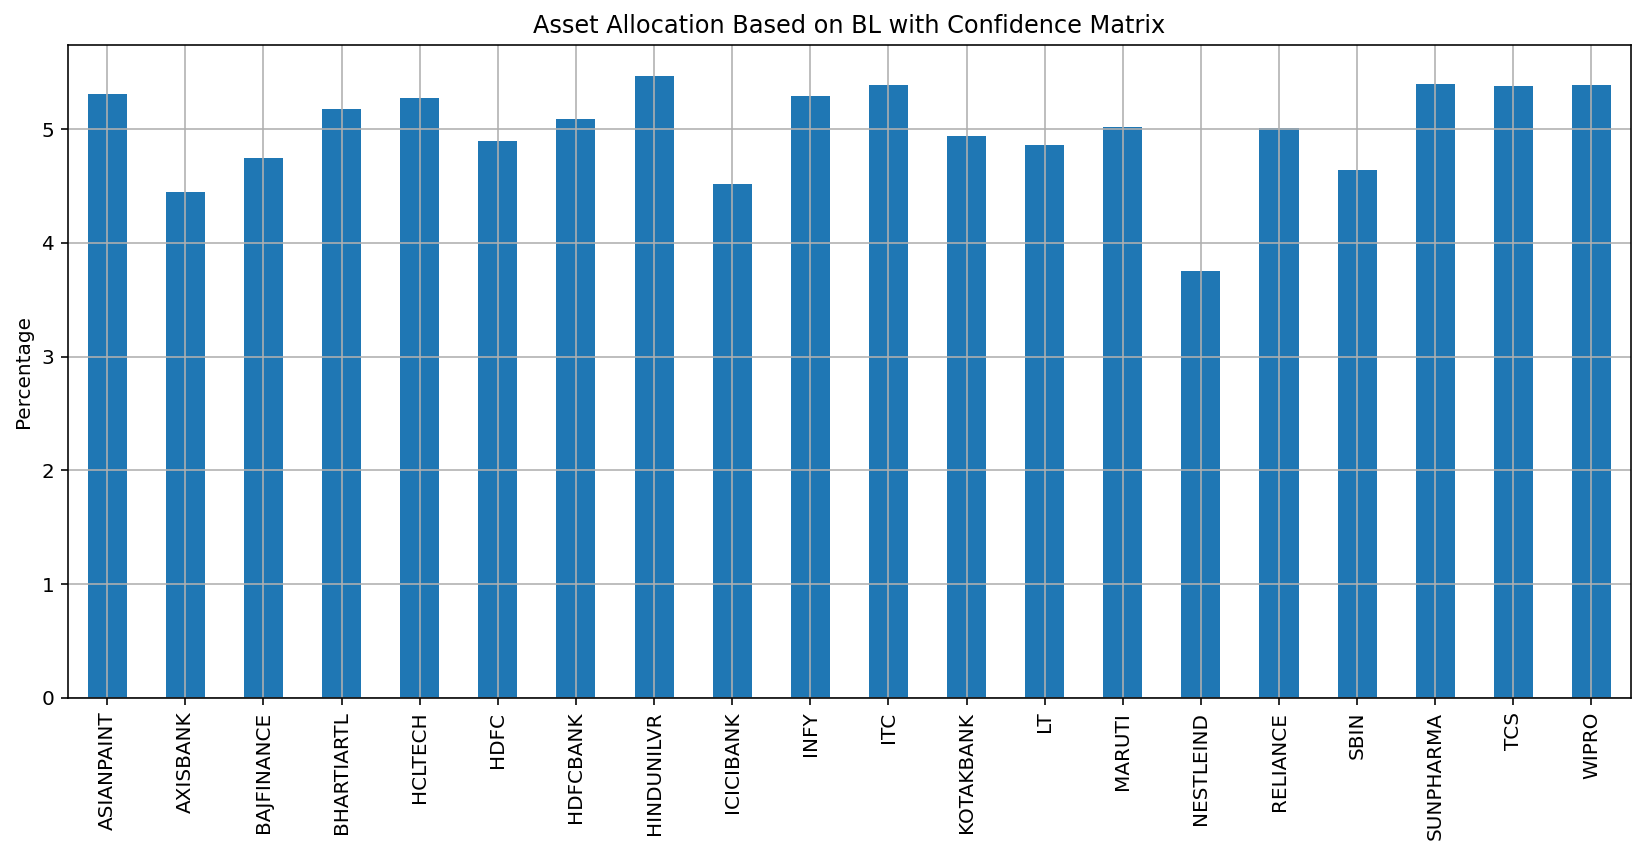

In [124]:
# plot the weights
wt_min_vola.plot.bar(figsize=(14,6), 
                    title = 'Asset Allocation Based on BL with Confidence Matrix', grid=True,legend=False);
plt.ylabel('Percentage')
plt.savefig('images/chart6', dpi=300)

In [126]:
# # data store path
# DATA_STORE = '../../../../machine-learning-for-trading-master/\
# machine-learning-for-trading-master/data/nse_asset.h5'

In [125]:
# with pd.HDFStore(DATA_STORE) as store:
#     print(store.info())

In [127]:
# # get the prices for top 20 companies
# with pd.HDFStore(DATA_STORE) as store:
#     prices = (store['/nse/nse500/prices'].loc[wt_min_vola.index])
# prices.head(2)

In [128]:
# # remove tickers where we have less than 10 years of data.
# min_obs = 2520
# nobs = prices.groupby(level='ticker').size()
# keep = nobs[nobs>min_obs].index

# prices = prices.loc[idx[keep,:], :]
# prices.info()

In [103]:
# date range for the backtesting
fromdate=datetime.datetime(2010, 1, 1)
todate=datetime.datetime(2020, 5, 29)

In [129]:
# # save the data as .csv file
# prices.to_csv('data/prices_all.csv')

In [130]:
# Read daily prices from csv
prices = pd.read_csv('data/prices_all.csv', index_col=['ticker','date'], parse_dates=True)
prices.head(2)

close  dividend       high        low       open  \
ticker     date                                                              
ASIANPAINT 2002-07-01  1.582765       0.0  22.466999  21.367001  21.367001   
           2002-07-02  1.599312       0.0  22.783001  21.370001  21.370001   

                       split    volume  
ticker     date                         
ASIANPAINT 2002-07-01    0.0   87810.0  
           2002-07-02    0.0  588615.0

In [106]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 101013 entries, (ASIANPAINT, 2002-07-01 00:00:00) to (WIPRO, 2020-06-18 00:00:00)
Data columns (total 7 columns):
close       101002 non-null float64
dividend    95926 non-null float64
high        101002 non-null float64
low         101002 non-null float64
open        101002 non-null float64
split       95926 non-null float64
volume      101002 non-null float64
dtypes: float64(7)
memory usage: 5.7+ MB


In [107]:
# create a tuple list of ticker and weight
assets_param = [(ind, wt_min_vola.loc[ind][0]) for ind in wt_min_vola.index]
print(assets_param)

[('ASIANPAINT', 5.28441665315375), ('AXISBANK', 4.47152531920427), ('BAJFINANCE', 4.74691235517464), ('BHARTIARTL', 5.16222714182934), ('HCLTECH', 5.2504461532056395), ('HDFC', 5.0638162817786405), ('HDFCBANK', 5.077600781503452), ('HINDUNILVR', 5.433074941230379), ('ICICIBANK', 4.53616440141471), ('INFY', 5.2712962410368), ('ITC', 5.36440419520248), ('KOTAKBANK', 4.94130668670622), ('LT', 4.8639620317400185), ('MARUTI', 5.006038291560871), ('NESTLEIND', 3.78581806463992), ('RELIANCE', 5.007139686898429), ('SBIN', 4.64901669683042), ('SUNPHARMA', 5.369237435310559), ('TCS', 5.3541294064693), ('WIPRO', 5.361467235110148)]


In [108]:
# define the strategy
class Strategy(bt.Strategy):
    # parameters for inputs    
    params = dict(
        assets = [],
        rebalance_months = [1,3,6,9]
    )
 
    # initialize
    def __init__(self):
        # create a dictionary of ticker:{'rebalanced': False, 'target_percent': target%}
        self.rebalance_dict = dict()
        for i, d in enumerate(self.datas):
            self.rebalance_dict[d] = dict()
            self.rebalance_dict[d]['rebalanced'] = False
            for asset in self.p.assets:
                if asset[0] == d._name:
                    self.rebalance_dict[d]['target_percent'] = asset[1]
 
    def next(self):
        # rebalance for the month in the list
        for i, d in enumerate(self.datas):
            dt = d.datetime.datetime()
            dname = d._name
            pos = self.getposition(d).size
 
            if dt.month in self.p.rebalance_months and self.rebalance_dict[d]['rebalanced'] == False:
                print('{} Sending Order: {} | Month {} | Rebalanced: {} | Pos: {}'.
                      format(dt, dname, dt.month,
                             self.rebalance_dict[d]['rebalanced'], pos ))
            
                self.order_target_percent(d, target=self.rebalance_dict[d]['target_percent']/100)
                self.rebalance_dict[d]['rebalanced'] = True
 
            # Reset the flage
            if dt.month not in self.p.rebalance_months:
                self.rebalance_dict[d]['rebalanced'] = False
                
    # notify the order if completed
    def notify_order(self, order):
        date = self.data.datetime.datetime().date()
 
        if order.status == order.Completed:
            print('{} >> Order Completed >> Stock: {},  Ref: {}, Size: {}, Price: {}'.
                  format(date, order.data._name, order.ref, order.size,
                         'NA' if not order.price else round(order.price,5)
                        ))

    # notify the trade if completed        
    def notify_trade(self, trade):
        date = self.data.datetime.datetime().date()
        if trade.isclosed:
            print('{} >> Notify Trade >> Stock: {}, Close Price: {}, Profit, Gross {}, Net {}'.
                  format(date, trade.data._name, trade.price, round(trade.pnl,2),round(trade.pnlcomm,2))
                 )
            


In [109]:
# starting cash
startcash = 500000

# 0.4% commission
commission = 0.004

#Create an instance of cerebro
cerebro = bt.Cerebro()

cerebro.broker.setcash(startcash)

# orders will not be checked to see if you can afford it before submitting them
cerebro.broker.set_checksubmit(False)

cerebro.broker.setcommission(commission=commission)

In [110]:
TICKERS = list(prices.index.get_level_values('ticker').unique())
print(TICKERS)

['ASIANPAINT', 'AXISBANK', 'BAJFINANCE', 'BHARTIARTL', 'HCLTECH', 'HDFC', 'HDFCBANK', 'HINDUNILVR', 'ICICIBANK', 'INFY', 'ITC', 'KOTAKBANK', 'LT', 'MARUTI', 'NESTLEIND', 'RELIANCE', 'SBIN', 'SUNPHARMA', 'TCS', 'WIPRO']


In [111]:
# load the data
for ticker, data in prices.groupby(level=0):
    if ticker in TICKERS:
        print(f"Adding ticker: {ticker}")
        data = bt.feeds.PandasData(dataname=data.droplevel(level=0),
                                   name=str(ticker),
                                   fromdate=fromdate,
                                   todate=todate,
                                   plot=False)
        cerebro.adddata(data)

Adding ticker: ASIANPAINT
Adding ticker: AXISBANK
Adding ticker: BAJFINANCE
Adding ticker: BHARTIARTL
Adding ticker: HCLTECH
Adding ticker: HDFC
Adding ticker: HDFCBANK
Adding ticker: HINDUNILVR
Adding ticker: ICICIBANK
Adding ticker: INFY
Adding ticker: ITC
Adding ticker: KOTAKBANK
Adding ticker: LT
Adding ticker: MARUTI
Adding ticker: NESTLEIND
Adding ticker: RELIANCE
Adding ticker: SBIN
Adding ticker: SUNPHARMA
Adding ticker: TCS
Adding ticker: WIPRO


In [112]:
#Add our strategy
cerebro.addstrategy(Strategy, assets=assets_param)

# add analyzers
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [113]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run the strategy. 
results = cerebro.run(stdstats=True, tradehistory=False)
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 500000.00
2010-01-04 00:00:00 Sending Order: ASIANPAINT | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: AXISBANK | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: BAJFINANCE | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: BHARTIARTL | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HCLTECH | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HDFC | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HDFCBANK | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HINDUNILVR | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: ICICIBANK | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: INFY | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: ITC | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: KOTAKBANK | Month 1 |

2010-09-01 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 144
2010-09-01 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 91
2010-09-01 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 770
2010-09-01 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 82
2010-09-01 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalanced: False | Pos: 305
2010-09-01 00:00:00 Sending Order: HDFC | Month 9 | Rebalanced: False | Pos: 34
2010-09-01 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 124
2010-09-01 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 98
2010-09-01 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 198
2010-09-01 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 134
2010-09-01 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 262
2010-09-01 00:00:00 Sending Order: KOTAKBANK | Month 9 | Rebalanced: False

2011-06-01 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 136
2011-06-01 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 108
2011-06-01 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 665
2011-06-01 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 81
2011-06-01 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 296
2011-06-01 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 35
2011-06-01 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 130
2011-06-01 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 101
2011-06-01 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 193
2011-06-01 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 144
2011-06-01 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 264
2011-06-01 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: Fal

2012-06-01 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 111
2012-06-01 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 127
2012-06-01 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 498
2012-06-01 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 88
2012-06-01 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 308
2012-06-01 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 39
2012-06-01 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 114
2012-06-01 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 85
2012-06-01 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 236
2012-06-01 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 158
2012-06-01 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 244
2012-06-01 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: Fals

2013-06-03 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 90
2013-06-03 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 125
2013-06-03 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 308
2013-06-03 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 120
2013-06-03 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 244
2013-06-03 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 42
2013-06-03 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 116
2013-06-03 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 75
2013-06-03 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 201
2013-06-03 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 172
2013-06-03 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 212
2013-06-03 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: Fals

2014-06-02 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 92
2014-06-02 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 158
2014-06-02 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 289
2014-06-02 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 144
2014-06-02 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 141
2014-06-02 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 52
2014-06-02 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 135
2014-06-02 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 90
2014-06-02 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 258
2014-06-02 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 144
2014-06-02 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 231
2014-06-02 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: Fals

2015-06-01 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 92
2015-06-01 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 100
2015-06-01 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 165
2015-06-01 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 232
2015-06-01 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 170
2015-06-01 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 53
2015-06-01 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 139
2015-06-01 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 88
2015-06-01 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 215
2015-06-01 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 169
2015-06-01 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 365
2015-06-01 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: Fals

2016-06-01 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 78
2016-06-01 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 144
2016-06-01 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 100
2016-06-01 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 225
2016-06-01 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 174
2016-06-01 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 58
2016-06-01 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 133
2016-06-01 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 88
2016-06-01 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 321
2016-06-01 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 138
2016-06-01 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 334
2016-06-01 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: Fals

2017-06-01 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 81
2017-06-01 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 137
2017-06-01 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 70
2017-06-01 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 248
2017-06-01 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 200
2017-06-01 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 57
2017-06-01 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 117
2017-06-01 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 100
2017-06-01 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 290
2017-06-01 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 180
2017-06-01 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 329
2017-06-01 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: Fals

2018-06-01 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 93
2018-06-01 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 164
2018-06-01 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 48
2018-06-01 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 211
2018-06-01 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 220
2018-06-01 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 54
2018-06-01 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 107
2018-06-01 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 81
2018-06-01 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 293
2018-06-01 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 190
2018-06-01 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 408
2018-06-01 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: False

2019-03-01 00:00:00 Sending Order: ASIANPAINT | Month 3 | Rebalanced: False | Pos: 87
2019-03-01 00:00:00 Sending Order: AXISBANK | Month 3 | Rebalanced: False | Pos: 159
2019-03-01 00:00:00 Sending Order: BAJFINANCE | Month 3 | Rebalanced: False | Pos: 40
2019-03-01 00:00:00 Sending Order: BHARTIARTL | Month 3 | Rebalanced: False | Pos: 390
2019-03-01 00:00:00 Sending Order: HCLTECH | Month 3 | Rebalanced: False | Pos: 245
2019-03-01 00:00:00 Sending Order: HDFC | Month 3 | Rebalanced: False | Pos: 55
2019-03-01 00:00:00 Sending Order: HDFCBANK | Month 3 | Rebalanced: False | Pos: 105
2019-03-01 00:00:00 Sending Order: HINDUNILVR | Month 3 | Rebalanced: False | Pos: 68
2019-03-01 00:00:00 Sending Order: ICICIBANK | Month 3 | Rebalanced: False | Pos: 278
2019-03-01 00:00:00 Sending Order: INFY | Month 3 | Rebalanced: False | Pos: 185
2019-03-01 00:00:00 Sending Order: ITC | Month 3 | Rebalanced: False | Pos: 428
2019-03-01 00:00:00 Sending Order: KOTAKBANK | Month 3 | Rebalanced: False

2020-01-01 00:00:00 Sending Order: NESTLEIND | Month 1 | Rebalanced: False | Pos: 8
2020-01-01 00:00:00 Sending Order: RELIANCE | Month 1 | Rebalanced: False | Pos: 98
2020-01-01 00:00:00 Sending Order: SBIN | Month 1 | Rebalanced: False | Pos: 329
2020-01-01 00:00:00 Sending Order: SUNPHARMA | Month 1 | Rebalanced: False | Pos: 292
2020-01-01 00:00:00 Sending Order: TCS | Month 1 | Rebalanced: False | Pos: 59
2020-01-01 00:00:00 Sending Order: WIPRO | Month 1 | Rebalanced: False | Pos: 503
2020-01-02 >> Order Completed >> Stock: ASIANPAINT,  Ref: 2182, Size: -1, Price: 1786.02441
2020-01-02 >> Order Completed >> Stock: AXISBANK,  Ref: 2183, Size: -4, Price: 748.70001
2020-01-02 >> Order Completed >> Stock: BAJFINANCE,  Ref: 2184, Size: -4, Price: 4221.59668
2020-01-02 >> Order Completed >> Stock: BHARTIARTL,  Ref: 2185, Size: -59, Price: 453.29999
2020-01-02 >> Order Completed >> Stock: HCLTECH,  Ref: 2186, Size: 19, Price: 570.04016
2020-01-02 >> Order Completed >> Stock: HDFC,  Ref:

In [114]:
# Extract inputs for pyfolio
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

In [115]:
# Extract inputs for pyfolio
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2010-01-04 00:00:00+00:00    0.000000
2010-01-05 00:00:00+00:00   -0.306618
Name: Strategy, dtype: float64

In [116]:
# Get the benchmark returns for comparison
benchmark = '^BSESN'
benchmark_rets= web.DataReader(benchmark, 'yahoo', start='2010-01-01',)['Adj Close'].pct_change().dropna()
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'S&P BSE-SENSEX'
benchmark_rets.head(2)

Date
2010-01-05 00:00:00+00:00    0.007262
2010-01-06 00:00:00+00:00    0.000842
Name: S&P BSE-SENSEX, dtype: float64

In [117]:
import seaborn as sns
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

In [118]:
# get performance statistics for strategy
pf.show_perf_stats(returns,)

Start date,2010-01-04
End date,2020-05-29
Total months,122
,Backtest
Annual return,15.794%
Cumulative returns,349.033%
Annual volatility,18.813%
Sharpe ratio,0.88
Calmar ratio,0.44
Stability,0.97
Max drawdown,-36.145%


In [119]:
# get performance statistics for benchmark
pf.show_perf_stats(benchmark_rets)

Start date,2010-01-05
End date,2020-05-29
Total months,121
,Backtest
Annual return,6.246%
Cumulative returns,84.661%
Annual volatility,17.474%
Sharpe ratio,0.43
Calmar ratio,0.16
Stability,0.90
Max drawdown,-38.07%


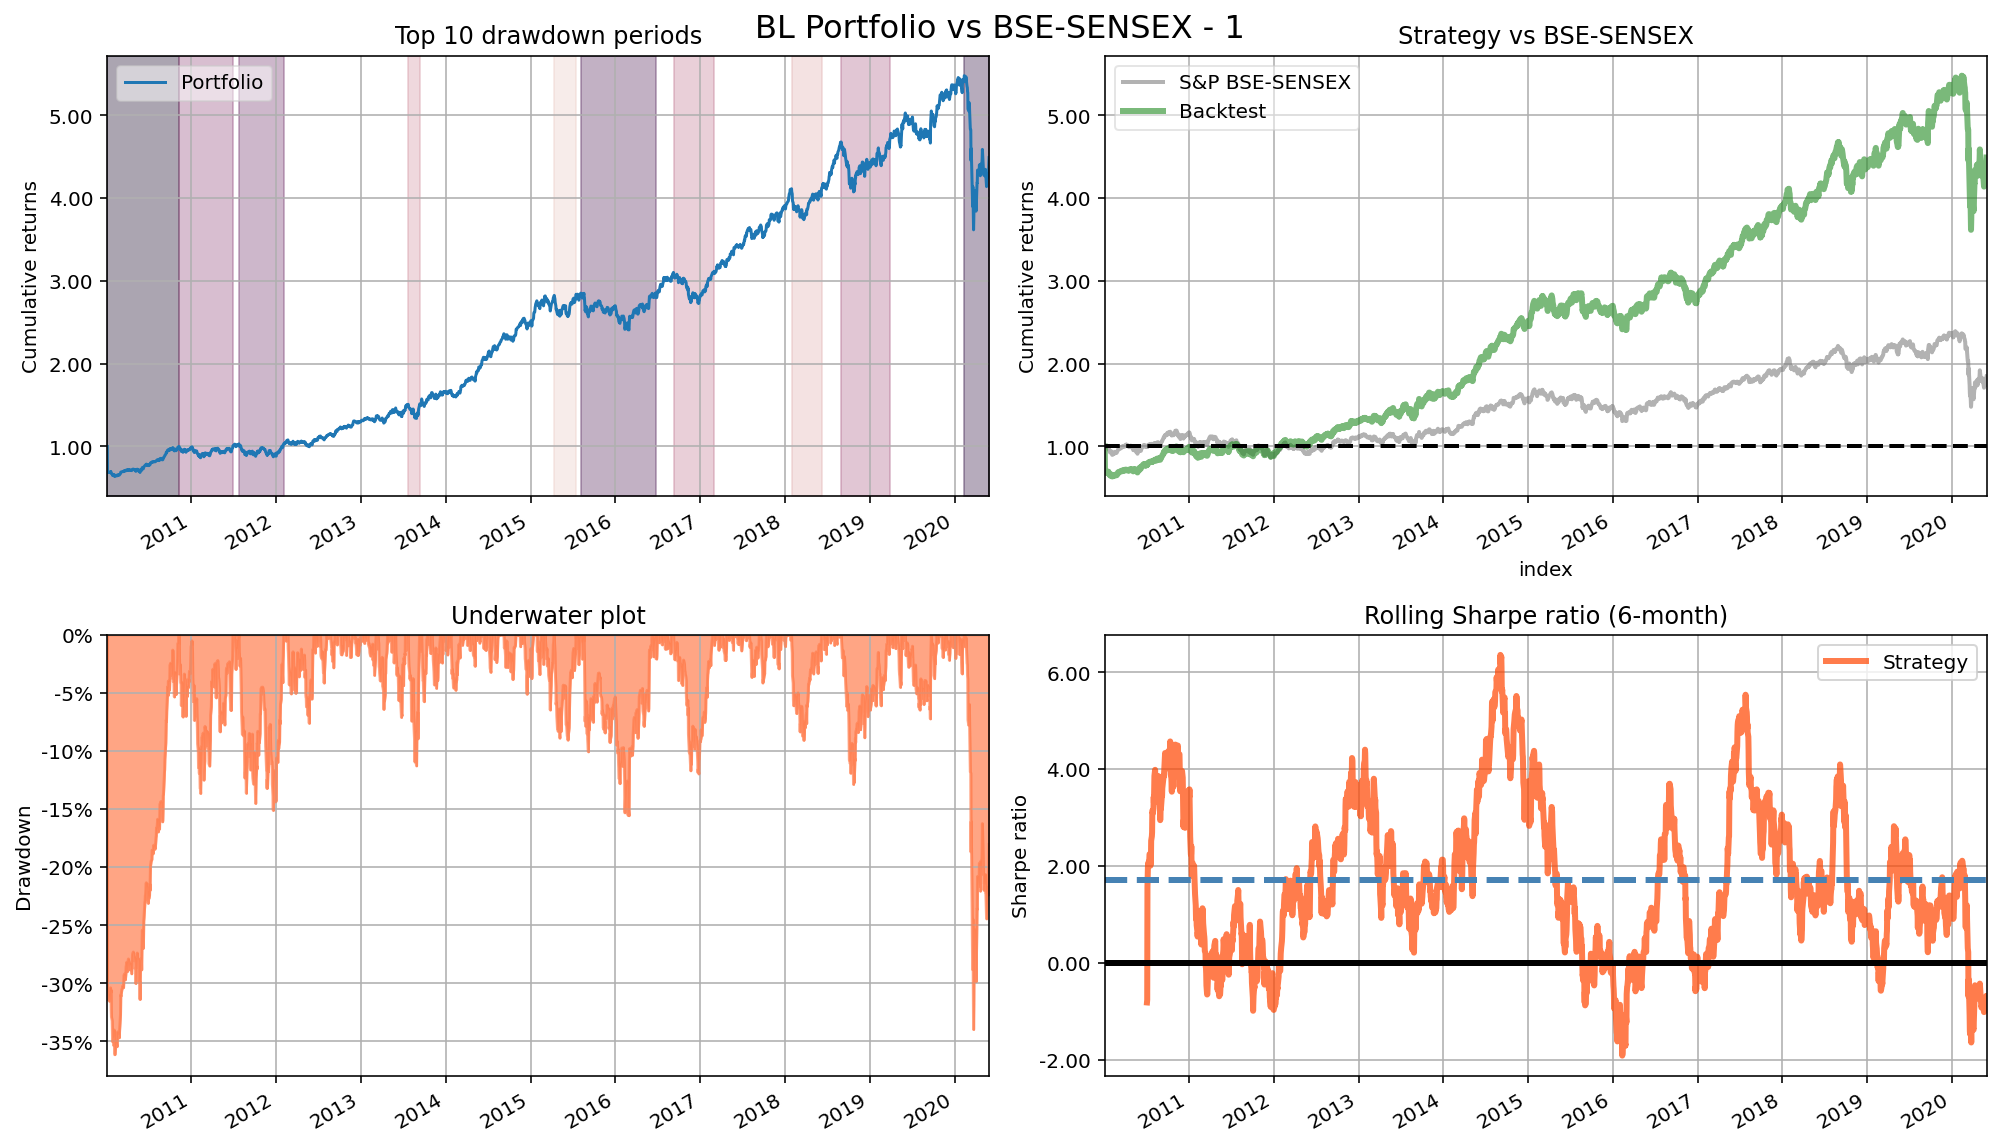

In [131]:
# plot performance for strategy
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8),constrained_layout=True)
axes = ax.flatten()

pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs BSE-SENSEX')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
fig.suptitle('BL Portfolio vs BSE-SENSEX - 1', fontsize=16, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('images/chart7', dpi=300)

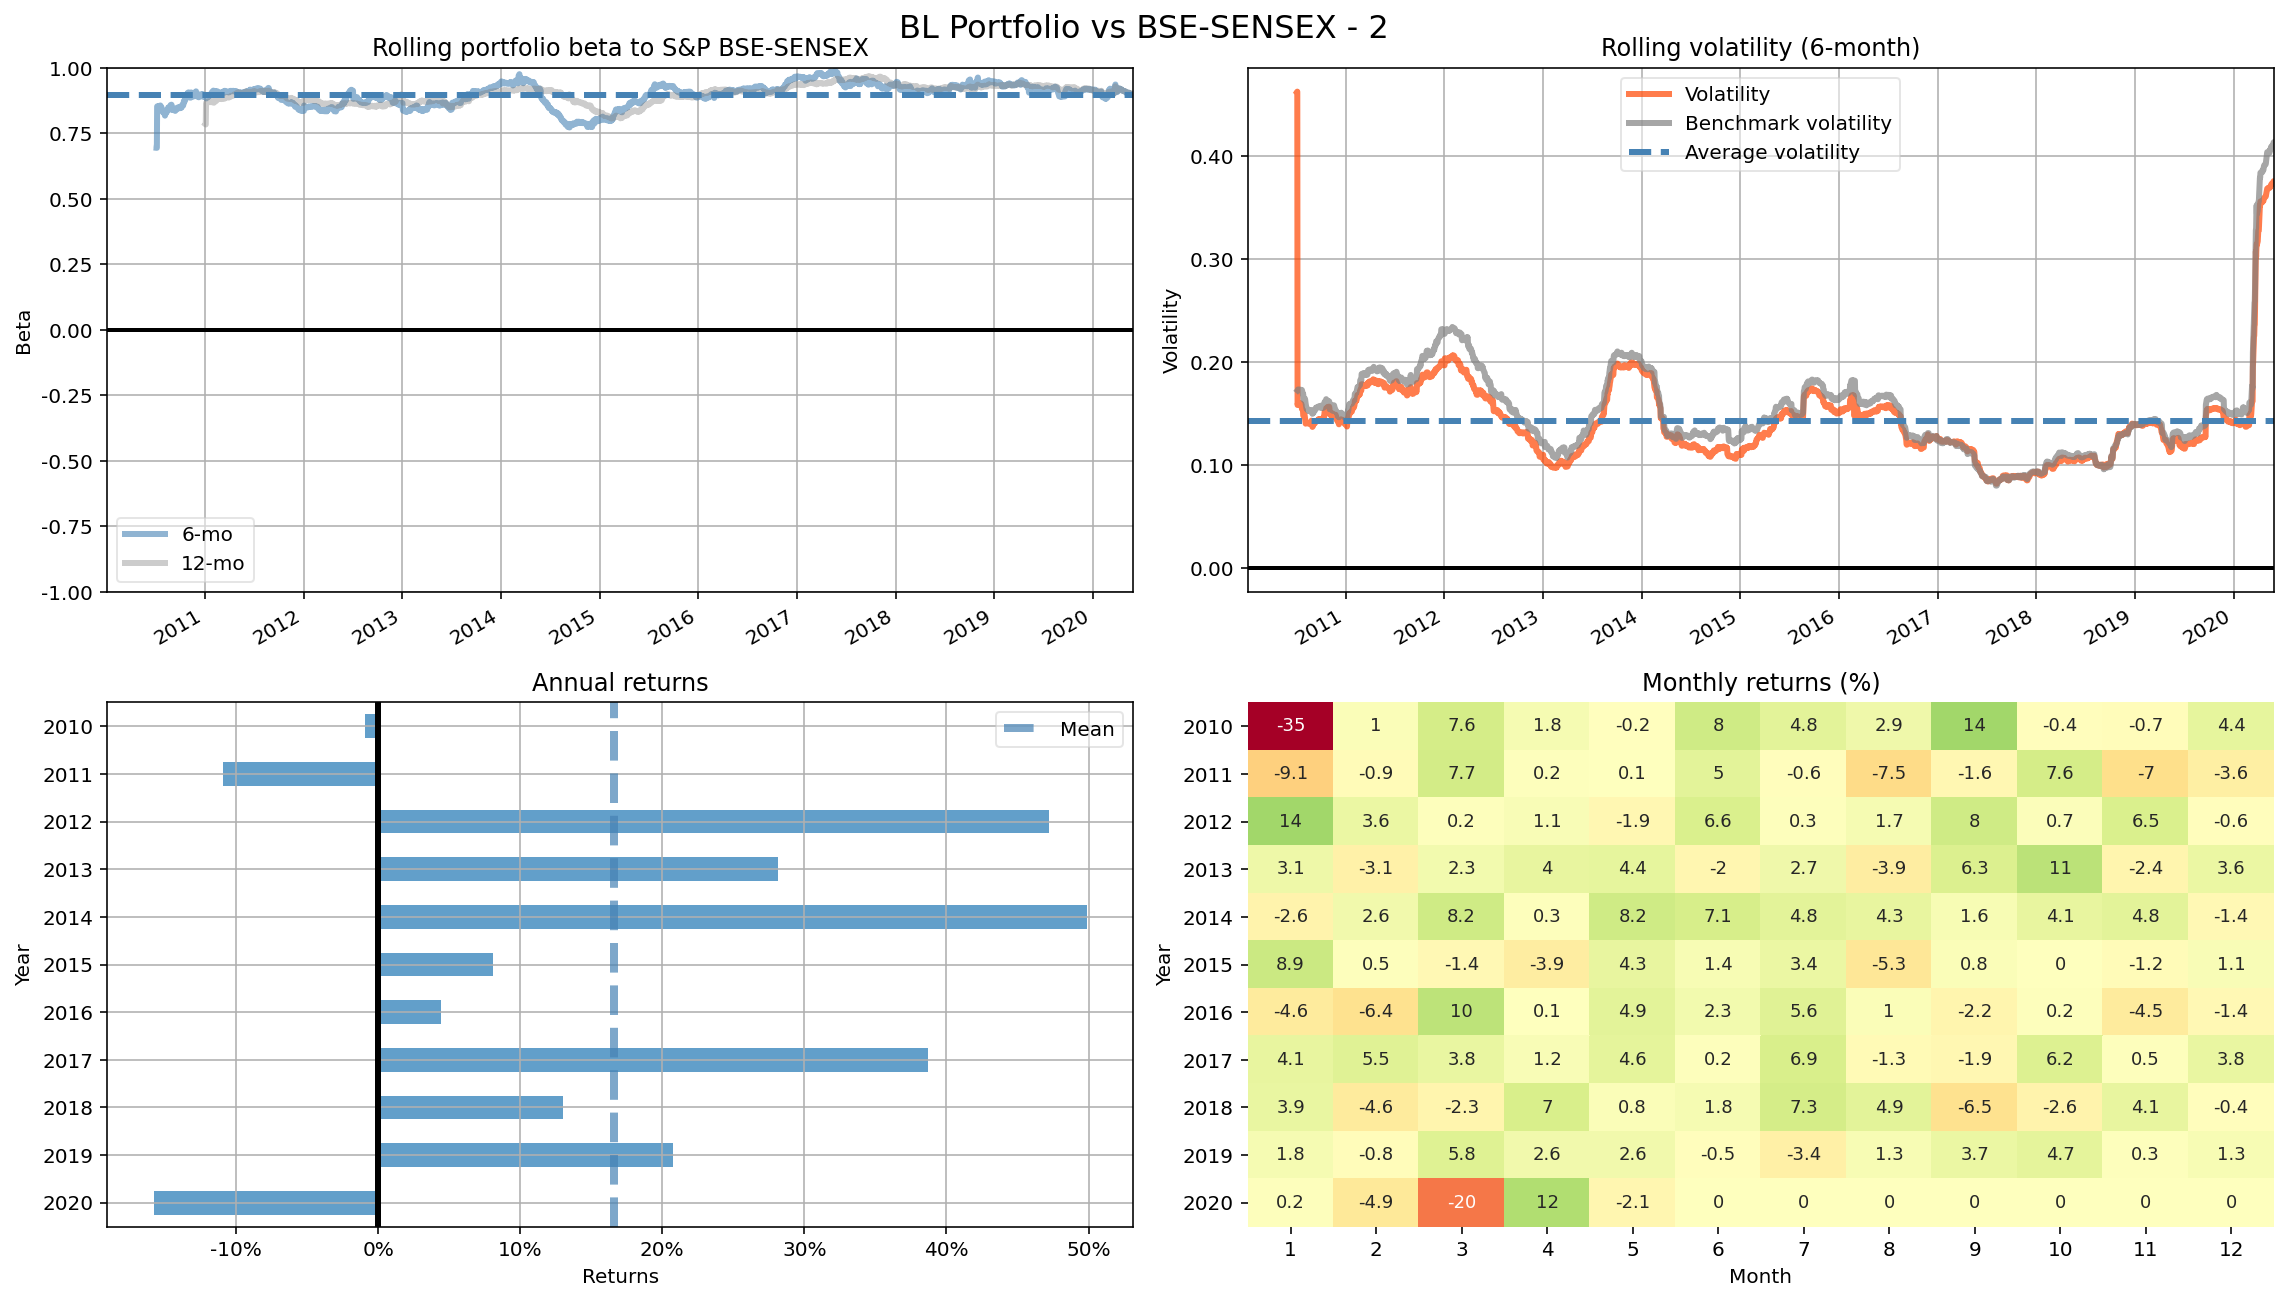

In [135]:
# plot performance
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
fig.suptitle('BL Portfolio vs BSE-SENSEX - 2', fontsize=16, y=1.0)


plt.tight_layout()
plt.savefig('images/chart8', dpi=300)